# Unidad 7: Redes neuronales recurrentes

## 7.1 Introducción

Usaremos redes neuronales que nos permiten modelar y predecir las series de tiempo lineales y no lineales, con alto grado de precisión, capturando las relaciones entre los datos sin conocimiento previo del modelo

## 7.2 Objetivo

Predecir valores futuros de las series de tiempo usando algoritmos propios de la inteligencia artificial para el tratamiento de las series de tiempo.

## 7.3 Acción

Para la primera entrega, deberán volver al documento en github que han venido elaborando a lo largo de las unidades anteriores, esta vez, para aplicar las redes neuronales ELMAN y Jordan, y su pronóstico al conjunto de datos con el que han venido trabajando.

### 7.3.1 Preparación de los datos

Previo al análisis detallado, es imperativo comprender el proceso de preparación de datos temporales para garantizar su idoneidad y coherencia en el estudio.

In [1]:
# importando librerias

# librerias para la transformación de datos
import pandas as pd
import numpy as np
from datetime import datetime

# libreria para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

#### 7.3.1.1 Recopilación de los datos

En este bloque, se carga el conjunto de datos desde un archivo CSV utilizando la biblioteca pandas. Se especifica el delimitador de campos y se visualizan las primeras filas del dataframe para verificar que los datos se han cargado correctamente.

In [2]:
# recopilación de datos
df_data = pd.read_csv('./dataset.csv',sep=';')
df_data.head()

,fechaoperacion,codigo,contenido,hora1,hora2,hora3,hora4,hora5,hora6,hora7,...,hora15,hora16,hora17,hora18,hora19,hora20,hora21,hora22,hora23,hora24
0,1/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),87.778212,77.778212,77.778212,77.778212,77.778212,77.778212,75.768212,...,75.768212,71.278212,69.067212,76.278212,77.778212,87.778212,87.778212,77.778212,77.778212,77.778212
1,2/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),76.278212,76.278212,76.278212,76.278212,76.278212,76.778212,76.778212,...,82.778212,82.778212,82.778212,81.768212,87.778212,87.778212,87.778212,82.778212,76.778212,76.778212
2,3/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),77.678212,77.678212,77.678212,77.678212,77.678212,77.678212,77.678212,...,82.778212,82.778212,82.778212,82.778212,87.778212,114.425212,87.778212,82.778212,77.678212,77.678212
3,4/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),77.778212,77.778212,77.778212,77.778212,77.778212,77.778212,77.778212,...,77.778212,77.778212,77.778212,85.778212,85.778212,87.778212,85.778212,85.778212,81.768212,77.778212
4,5/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),86.778212,86.778212,86.778212,86.778212,86.778212,86.778212,88.278212,...,88.278212,88.278212,88.278212,88.278212,88.278212,91.134212,88.278212,88.278212,86.778212,86.778212


#### 7.3.1.2 Transformación de Datos

Este bloque define una función para transformar el dataframe original. Se realiza una copia del dataframe, se convierte la columna de fechas a un formato de fecha adecuado, y se agregan nuevas columnas para el año, mes y día. Luego, se seleccionan y reorganizan las columnas, y finalmente, se pivotea la tabla para facilitar su uso en análisis posteriores.

In [3]:
def trf_data(df_data):
    
    # copia del dataframe
    df = df_data.copy()
    
    # transformación de fechas
    df['fechaoperacion'] = pd.to_datetime(df['fechaoperacion'], format='%d/%m/%Y')
    
    # agregando las columnas de fechas
    df['ano'] = df.apply(lambda x: x['fechaoperacion'].year ,axis=1)
    df['mes'] = df.apply(lambda x: x['fechaoperacion'].month ,axis=1)
    df['dia'] = df.apply(lambda x: x['fechaoperacion'].day ,axis=1)
    
    # selección de columnas
    df = df[['fechaoperacion','ano','mes','dia', 'hora1', 'hora2', 'hora3','hora4', 'hora5', 'hora6', 'hora7', 'hora8', 'hora9', 'hora10','hora11', 'hora12', 'hora13', 'hora14', 'hora15', 'hora16', 'hora17','hora18', 'hora19', 'hora20', 'hora21', 'hora22', 'hora23', 'hora24']]
    
    # Convertir la tabla
    list_id = [i.lower() for i in df.columns if not 'hora' in i]
    list_value = [i.lower() for i in df.columns if 'hora' in i]
    
    # pivotear la tabla
    df = df.melt(id_vars=list_id,value_vars=list_value,var_name='periodo',value_name='valor')
    
    return df

In [4]:
# dataset trasnformado
df = trf_data(df_data)
df.head()

,fechaoperacion,ano,mes,dia,periodo,valor
0,2006-01-01,2006,1,1,hora1,87.778212
1,2006-01-02,2006,1,2,hora1,76.278212
2,2006-01-03,2006,1,3,hora1,77.678212
3,2006-01-04,2006,1,4,hora1,77.778212
4,2006-01-05,2006,1,5,hora1,86.778212


#### 7.3.1.3 Remuestreo de la serie temporal

En este bloque, se crea una copia del dataframe transformado y se remuestrean los datos a valores mensuales. Se agrupan los datos por fecha y se calcula la media mensual. Luego, se seleccionan las columnas relevantes y se visualiza el nuevo dataframe remuestreado.

In [5]:
# remuestreando la serie de tiempo a valores mensuales

# creando una copia del dataframe
df_vcm = df.copy()

df_vcm = df_vcm[['ano','mes','valor']]

# creando el groupby
df_vcm = df_vcm.groupby(by=['ano','mes']).mean().reset_index()

# 
df_vcm['fechaoperacion'] = df_vcm.apply(lambda x: datetime(int(x['ano']),int(x['mes']),1),axis=1)

#  remuestreando el dataframe a mensual
df_vcm = df_vcm[['fechaoperacion','valor']]

# mostrando el dataframe transformado
df_vcm

,fechaoperacion,valor
0,2006-01-01,79.026486
1,2006-02-01,75.520919
2,2006-03-01,65.787447
3,2006-04-01,54.012347
4,2006-05-01,53.819582
...,...,...
211,2023-08-01,528.887237
212,2023-09-01,1017.549693
213,2023-10-01,1013.522208
214,2023-11-01,500.608645


### 7.3.2 Red neuronal Artificial: ELMAN

La red neuronal de Elman, introducida por Jeffrey Elman en 1990, es una variante de las redes neuronales recurrentes (RNN) diseñada para modelar secuencias temporales y datos que dependen del contexto histórico. A diferencia de las RNN simples, las redes de Elman incorporan una capa de contexto que almacena activaciones previas de la capa oculta, permitiendo que la red recuerde información de estados anteriores y mejore su capacidad para detectar patrones en secuencias.

#### 7.3.2.1 Preparación de datos para el modelo

La preparación de datos es una etapa crítica en el desarrollo de modelos de machine learning. A continuación, se describen los pasos específicos realizados para preparar los datos antes de entrenar una red neuronal recurrente (RNN).

**1. Copia del DataFrame Original:** Se inicia el proceso creando una copia del DataFrame original. Esta práctica asegura que los datos originales permanezcan intactos y disponibles para cualquier referencia futura o para la validación de resultados. Además, permite realizar manipulaciones y transformaciones necesarias sin riesgo de modificar la fuente original de datos.

**2. Escalado de Datos:** Para garantizar que todos los valores se encuentren en un rango uniforme y facilitar el proceso de aprendizaje del modelo, los datos son escalados entre 0 y 1. Este paso, conocido como normalización, es esencial para mejorar la convergencia y la estabilidad del modelo durante el entrenamiento, reduciendo posibles sesgos y acelerando el proceso de optimización.

**3. Creación de Secuencias:** Las RNNs requieren datos secuenciales para aprender patrones temporales y dependencias a lo largo del tiempo. Por lo tanto, se crean secuencias de datos a partir del DataFrame escalado. Estas secuencias actúan como ventanas deslizantes que capturan una serie de observaciones consecutivas, permitiendo a la RNN captar relaciones temporales y predecir valores futuros basándose en datos históricos. En este caso, se define una longitud de secuencia (seq_length) de 12. Esto significa que cada secuencia contendrá 12 observaciones consecutivas, proporcionando al modelo una ventana de tiempo suficientemente amplia para aprender patrones relevantes.

**4. Remodelado de la Entrada:** El último paso en la preparación de datos consiste en remodelar las secuencias generadas para que cumplan con los requisitos de entrada de la RNN. Este proceso de 'reshape' asegura que las dimensiones de los datos coincidan con la arquitectura del modelo, facilitando su ingesta y procesamiento por la red neuronal. Normalmente, las secuencias se reestructuran en un formato tridimensional que incluye el número de muestras, la longitud de las secuencias (en este caso, 12) y el número de características.



In [6]:
# librerias para implementar el modelo ELMAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [7]:
# creando copia del dataframe
data = df_vcm.copy()

# Escalar los datos
scaler = MinMaxScaler()
data['valor'] = scaler.fit_transform(data[['valor']])

# Crear secuencias de datos para la red recurrente
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 12
data_vf = data['valor'].values.reshape(-1, 1)
X, y = create_sequences(data_vf, seq_length)

# Reshape input to be [samples, time steps, features] which is required for RNN
X = X.reshape(X.shape[0], X.shape[1], 1)

#### 7.3.2.2 División de datos de entrenamiento y test

Para esta fase, se adoptó una estrategia de división sin mezcla de datos (shuffle=False). Esto es particularmente importante en el contexto de series temporales o datos secuenciales, donde mantener el orden cronológico es crucial para preservar la integridad de las relaciones temporales en los datos. 

- **Conjunto de Entrenamiento (Training Set):** Comprende el 80% de los datos originales. Este subconjunto se utiliza para entrenar el modelo, permitiéndole aprender patrones, tendencias y relaciones inherentes a los datos.

- **Conjunto de Prueba (Test Set):** Constituye el 20% restante de los datos. Este subconjunto se reserva para evaluar el rendimiento del modelo una vez completado el entrenamiento. Al no haber sido expuesto al modelo durante la fase de entrenamiento, proporciona una evaluación imparcial de la capacidad del modelo para generalizar a nuevos datos.

In [8]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#### 7.3.2.3 Creación y entrenamiento del modelo Elman RNN

En esta sección, se describe el proceso de creación y entrenamiento de un modelo de red neuronal recurrente (RNN) de tipo Elman. Este modelo es especialmente adecuado para datos secuenciales y series temporales debido a su capacidad para capturar dependencias a lo largo del tiempo.

El modelo Elman RNN se ha diseñado y compilado con las siguientes características:

**1. Estructura del Modelo:** Se implementa una red neuronal Elman con una capa oculta compuesta por 50 neuronas.
**2. Secuencia de Datos:** La red recibe secuencias de 12 datos de entrada y produce una salida.

**3. Configuración de la Capa:** 

- 3.1 Capa SimpleRNN: Con 50 neuronas y activación 'tanh' para permitir la captura de patrones no lineales en los datos. La configuración return_sequences=False indica que la capa no devuelve secuencias completas, sino un único vector de salida por secuencia de entrada.

- 3.2 Capa Dense: Una capa densa con una neurona de salida para predecir el valor final de cada secuencia.
    
**4. Compilación del Modelo:** Se utiliza el optimizador 'adam' y la función de pérdida 'mean_squared_error', adecuada para problemas de regresión.

In [9]:
# Crear el modelo Elman RNN
model_elman = Sequential()
model_elman.add(SimpleRNN(50, input_shape=(12, 1), activation='tanh', return_sequences=False))
model_elman.add(Dense(1))
model_elman.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model_elman.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)

c:\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0342
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0102
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0141
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0048
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0049
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068
Epoch 9/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0044
Epoch 10/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060
Epoch 11/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059
Epoch 12/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088
Epoch 13/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071
Epoch 14/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072
Epoch 15/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 1

#### 7.3.2.4 Función de predicción

Una vez entrenado el modelo Elman RNN, es fundamental disponer de una función de predicción que permita extrapolar los resultados del modelo a datos futuros. En esta sección, se detalla la definición y el uso de una función diseñada para realizar predicciones utilizando el modelo entrenado, con un enfoque específico en la predicción de datos para los próximos 12 meses del año 2024.

In [10]:
def pron_prec(data,num_meses,model):
    
    # lista de predicciones
    list_pred = []
    
    # tomando la ultima sequencia del historico
    x_ult = data[-1]
    
    for i in range(num_meses):
        
        # convirtiendo la estructura del dato para la RNN
        x_ult = x_ult.reshape(1,12,1)
        
        # realizando la predicción
        pred = model.predict(x_ult)
        
        # agregando en la lista
        list_pred.append(pred[0,0])
        
        # agregando el valor de la predicción
        x_ult = np.append(x_ult[0][1:],pred[0,0])
        
    pred_model = np.array(list_pred)
    pred_model = pred_model.reshape(1,12,1)
    
    return pred_model
    

In [11]:
# Realizar pronóstico de los proximos 12 meses
pred_pron = pron_prec(X,12,model_elman)
pred_pron

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


array([[[0.38040742],
        [0.38878527],
        [0.4866166 ],
        [0.3006445 ],
        [0.10565289],
        [0.16396062],
        [0.18003066],
        [0.19160825],
        [0.14650506],
        [0.14604178],
        [0.16412398],
        [0.15487538]]], dtype=float32)

#### 7.3.2.5 Visualización de los resultados

La visualización de los resultados obtenidos mediante el modelo Elman RNN y sus predicciones es crucial para evaluar su precisión y proporcionar una representación gráfica clara de las tendencias futuras.

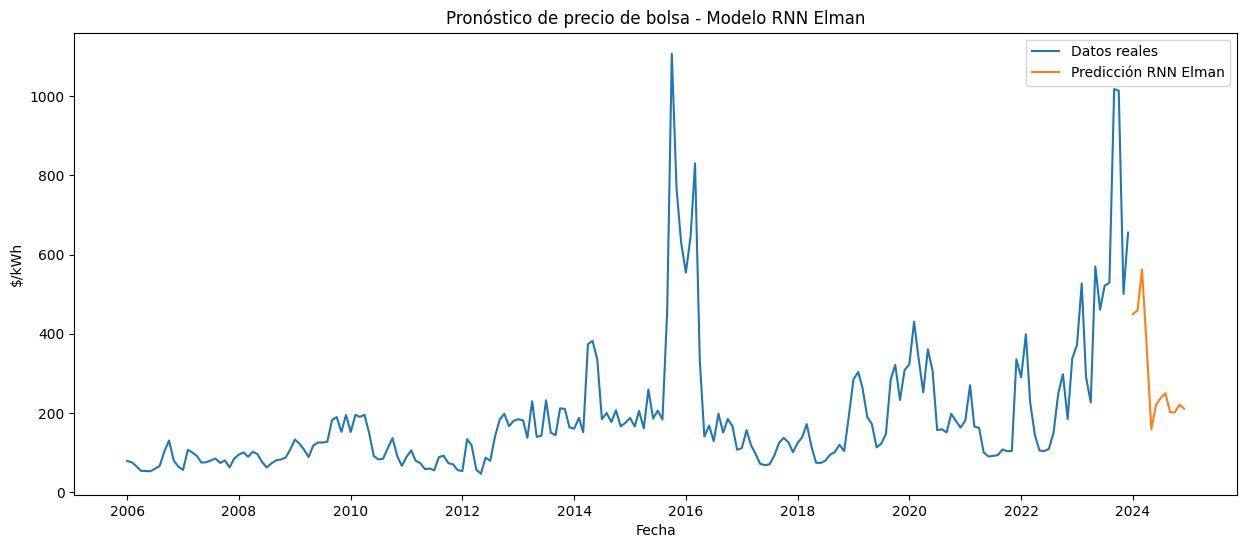

In [15]:
# inviertiendo la escala de los datos del pronóstico de los 12 meses siguientes
new_pred = scaler.inverse_transform(pred_pron[0])

# inviritendo la escala de los datos de entrada al modelo
data_pru = scaler.inverse_transform(data_vf)

# creando las fechas para las predicciones futuras
future_dates = pd.date_range(data['fechaoperacion'].iloc[-1], periods=13, freq='M')[1:]
future_dates = pd.DataFrame({'fecha':future_dates})
future_dates['fechaoperacion'] = future_dates.apply(lambda x: datetime(x['fecha'].year,x['fecha'].month,1),axis=1)
future_dates = future_dates['fechaoperacion']

# Plotear los resultados
plt.figure(figsize=(15, 6))
plt.plot(data['fechaoperacion'], data_pru, label='Datos reales')
plt.plot(future_dates, new_pred, label='Predicción RNN Elman')
plt.title('Pronóstico de precio de bolsa - Modelo RNN Elman')
plt.xlabel('Fecha')
plt.ylabel('$/kWh')
plt.legend()
plt.show()

### 7.3.3 Red neuronal Artificial: JORDAN

En esta sección, se aborda la implementación y entrenamiento de una red neuronal recurrente de tipo Jordan. Este tipo de red es especialmente útil para problemas de series temporales y datos secuenciales, ya que incorpora retroalimentación de las salidas pasadas en las entradas futuras, proporcionando así una estructura robusta para capturar patrones temporales complejos.

#### 7.3.3.1 Definición y Entrenamiento del Modelo Jordan RNN

El modelo Jordan RNN se caracteriza por su arquitectura específica, donde la salida de la red en el paso anterior se utiliza como entrada adicional en el paso actual. Este diseño permite a la red capturar dependencias a largo plazo y mejorar la capacidad de predicción. Los principales componentes del modelo incluyen:

- Capa RNN: Una capa recurrente con 50 neuronas, que procesa las secuencias de entrada y genera salidas que se reutilizan en los siguientes pasos de tiempo.
- Concatenación de Salidas: La salida generada por la capa RNN se concatena con la última entrada de la secuencia, proporcionando un contexto adicional a la red.
- Capa de Salida: Una capa densa que produce la predicción final.

El entrenamiento del modelo se lleva a cabo utilizando los datos de entrenamiento previamente preparados. Durante esta fase, el modelo ajusta sus parámetros internos para minimizar la función de pérdida, aprendiendo así a realizar predicciones precisas.

In [16]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense, concatenate
from tensorflow.keras.models import Model

In [17]:
# Definir la red Jordan
input_layer = Input(shape=(12, 1))
rnn_layer = SimpleRNN(50, activation='relu')(input_layer)
context_layer = concatenate([rnn_layer, input_layer[:, -1, :]])
output_layer = Dense(1)(context_layer)

model_jordan = Model(inputs=input_layer, outputs=output_layer)

# Compilar el modelo
model_jordan.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
history_jordan = model_jordan.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0918 - val_loss: 0.1546
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0469 - val_loss: 0.0852
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0279 - val_loss: 0.0575
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0255 - val_loss: 0.0543
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0234 - val_loss: 0.0537
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0282 - val_loss: 0.0484
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0200 - val_loss: 0.0434
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0182 - val_loss: 0.0418
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0131 - val_loss: 0.0358
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103 - val_loss: 0.0359
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0184 - val_loss: 0.0350
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0083 - val_loss: 

#### 7.3.3.2 Predicciones con el Modelo Jordan

Una vez completado el entrenamiento del modelo Jordan RNN, el siguiente paso es utilizar este modelo para realizar predicciones. En esta sección, se detalla el proceso de generación de predicciones para los próximos 12 meses utilizando los datos y el modelo Jordan entrenado.

In [18]:
# Realizar predicción de los proximos 12 meses con el modelo Jordan
pred_pron_jordan = pron_prec(X,12,model_jordan)
pred_pron_jordan

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


array([[[ 0.40430132],
        [ 0.45290634],
        [ 0.4391083 ],
        [ 0.1525603 ],
        [-0.02714666],
        [ 0.05936821],
        [ 0.11451667],
        [ 0.11473879],
        [ 0.08150247],
        [ 0.10213182],
        [ 0.11031999],
        [ 0.10511155]]], dtype=float32)

#### 7.3.3.3 Visualización de los Resultados

La visualización de los resultados obtenidos mediante el modelo Jordan RNN es una etapa crucial para interpretar y evaluar la precisión de las predicciones. En esta sección, se detalla el proceso de generación de fechas futuras para las predicciones y la representación gráfica de los datos históricos junto con las predicciones.

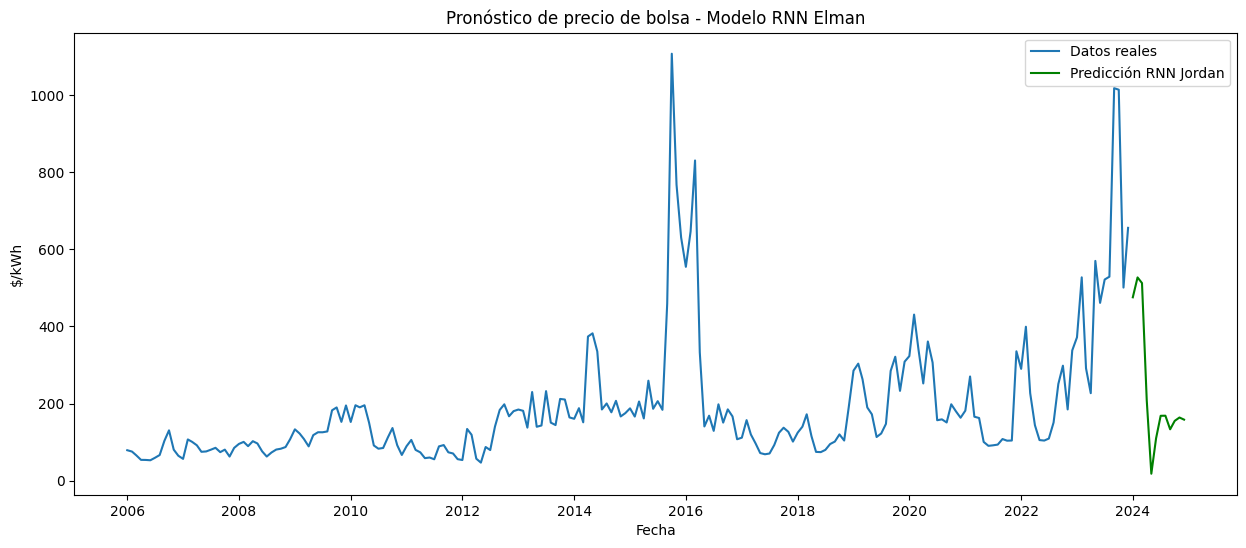

In [21]:
# inviertiendo la escala de los datos del pronóstico de los 12 meses siguientes
new_pred_jordan = scaler.inverse_transform(pred_pron_jordan[0])

# invirtiendo la escala de los datos del modelo entrada
data_pru_jordan = scaler.inverse_transform(data_vf)

# Plotear los resultados
plt.figure(figsize=(15, 6))
plt.plot(data['fechaoperacion'], data_pru, label='Datos reales')
plt.plot(future_dates, new_pred_jordan, label='Predicción RNN Jordan',color='green')
plt.title('Pronóstico de precio de bolsa - Modelo RNN Elman')
plt.xlabel('Fecha')
plt.ylabel('$/kWh')
plt.legend()
plt.show()

### 7.3.4 Comparación de Modelos

En esta sección, se detalla el proceso de comparación de modelos de predicción de series temporales utilizando PyCaret, una biblioteca de Python que facilita la experimentación y comparación de múltiples modelos. La finalidad es identificar el modelo más adecuado para las necesidades específicas del proyecto, garantizando así predicciones precisas y confiables.

#### 7.3.4.1 Configuración y Comparación de Modelos en PyCaret

La comparación de modelos en PyCaret sigue un enfoque sistemático que incluye la inicialización del experimento, la configuración de parámetros específicos y la evaluación comparativa de varios modelos de predicción.

El primer paso en el uso de PyCaret para la comparación de modelos es la inicialización del entorno de experimentación. PyCaret proporciona una plataforma integrada que simplifica la configuración y ejecución de experimentos de modelado de series temporales.

In [314]:
import pycaret
from sklearn import preprocessing
from pycaret.time_series import TSForecastingExperiment

In [315]:
# creando copia del dataframe original
df_pron = df_vcm.copy()
df_pron.set_index('fechaoperacion',inplace=True)


In [316]:
# Inicializar el experimento de PyCaret para series temporales
exp = TSForecastingExperiment()

Una vez inicializado el entorno, se procede a configurar el experimento con los datos y parámetros específicos del proyecto. Esto incluye definir la columna objetivo, establecer los parámetros de validación cruzada y cualquier otra configuración relevante que pueda influir en el rendimiento del modelo.

In [317]:
# Configurar el experimento
exp.setup(data=df_pron, target='valor', fold=3, session_id=123)

,Description,Value
0,session_id,123
1,Target,valor
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(216, 1)"
5,Transformed data shape,"(216, 1)"
6,Transformed train set shape,"(215, 1)"
7,Transformed test set shape,"(1, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


Con el experimento configurado, PyCaret permite comparar múltiples modelos de predicción de series temporales de manera automatizada. La biblioteca evalúa el rendimiento de cada modelo utilizando métricas predefinidas, como el error cuadrático medio (MSE) y el coeficiente de determinación (R²).

La tabla a continuación resume las métricas de rendimiento de varios modelos evaluados. Las métricas incluyen MASE (Mean Absolute Scaled Error), RMSSE (Root Mean Squared Scaled Error), MAE (Mean Absolute Error), RMSE (Root Mean Squared Error), MAPE (Mean Absolute Percentage Error), SMAPE (Symmetric Mean Absolute Percentage Error), y el tiempo total de entrenamiento (TT en segundos).

In [242]:
# Comparar modelos para encontrar el más óptimo
best_model = exp.compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,TT (Sec)
auto_arima,Auto ARIMA,3.0574,1.8048,277.0635,277.0635,0.3727,0.3862,4.2400
ets,ETS,3.3344,1.9612,304.0979,304.0979,0.4185,0.3977,0.0467
theta,Theta Forecaster,3.6596,2.1526,334.3701,334.3701,0.4911,0.4335,0.0267
naive,Naive Forecaster,3.6695,2.1597,335.2012,335.2012,0.5029,0.4378,1.6567
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,3.7022,2.1786,336.1190,336.1190,0.4018,0.4493,0.1400
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,3.7307,2.1962,339.5088,339.5088,0.4543,0.4541,0.1467
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,3.7307,2.1962,339.5087,339.5087,0.4543,0.4541,0.1667
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,3.7311,2.1964,339.5458,339.5458,0.4543,0.4541,0.1467
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,3.7313,2.1965,339.5634,339.5634,0.4544,0.4541,0.0400
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,3.7313,2.1965,339.5625,339.5625,0.4544,0.4541,0.0800


c:\Python\Python311\Lib\site-packages\pycaret\internal\pycaret_experiment\supervised_experiment.py:713: UserWarning: Unsupported estimator `ensemble_forecaster` for method `compare_models()`, removing from model_library
  warnings.warn(
c:\Python\Python311\Lib\site-packages\pycaret\time_series\forecasting\oop.py:2694: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_results = pd.concat((model_results, model_avgs), axis=0)
c:\Python\Python311\Lib\site-packages\pycaret\time_series\forecasting\oop.py:2694: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, ex

#### 7.3.4.2 Selección del Mejor Modelo

El modelo Auto ARIMA se destaca por tener las métricas MASE y RMSSE más bajas, lo que indica que tiene un error absoluto y cuadrático más pequeño en comparación con los otros modelos. Esto lo posiciona como el modelo más preciso para esta tarea específica.

In [244]:
model_auto_arima = exp.create_model('auto_arima')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2023-08,5.8648,3.4894,520.9399,520.9399,0.5120,0.6881
1,2023-09,0.1467,0.0852,13.5211,13.5211,0.0133,0.0133
2,2023-10,3.1607,1.8399,296.7296,296.7296,0.5927,0.4572
Mean,NaT,3.0574,1.8048,277.0635,277.0635,0.3727,0.3862
SD,NaT,2.3356,1.3900,207.6191,207.6191,0.2562,0.2800


c:\Python\Python311\Lib\site-packages\pycaret\time_series\forecasting\oop.py:2694: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_results = pd.concat((model_results, model_avgs), axis=0)


#### 7.3.4.3 Predicciones con el Modelo Auto ARIMA

En esta sección, se presentan las predicciones realizadas utilizando el modelo Auto ARIMA, el cual ha sido identificado como el más óptimo según las métricas de rendimiento evaluadas previamente.

In [318]:
# Realizar predicciones con el modelo final para los próximos 12 meses
future_dates_aarima = exp.predict_model(model_auto_arima, fh=13)

# Mostrar las predicciones
print(future_dates_aarima)

           y_pred
2023-12  494.7846
2024-01  618.9805
2024-02  767.7346
2024-03  587.5322
2024-04  460.6507
2024-05  684.6863
2024-06  717.5609
2024-07  642.2814
2024-08  563.1734
2024-09  612.9749
2024-10  707.7537
2024-11  628.8741
2024-12  590.3319


#### 7.3.4.3 Evaluación de resultados

A continuación se muestran las predicciones generadas por el modelo Auto ARIMA para los próximos 12 meses. Estas predicciones son fundamentales para la planificación estratégica y la toma de decisiones, proporcionando una visión clara de las tendencias esperadas en los datos analizados.

In [319]:
fechaperiodo = [i for i in future_dates_aarima.index]
valor = [str(i[0]) for i in future_dates_aarima.values]

ab = pd.DataFrame({'fecha':fechaperiodo,'valor':valor})
ab.info()

ab['ano'] = ab.apply(lambda x: x['fecha'].to_timestamp(),axis=1)
ab['ano'] = pd.to_datetime(ab['ano'], format='%Y-%m-%d')
ab['valor'] = ab.apply(lambda x: float(x['valor']),axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype    
---  ------  --------------  -----    
 0   fecha   13 non-null     period[M]
 1   valor   13 non-null     object   
dtypes: object(1), period[M](1)
memory usage: 340.0+ bytes


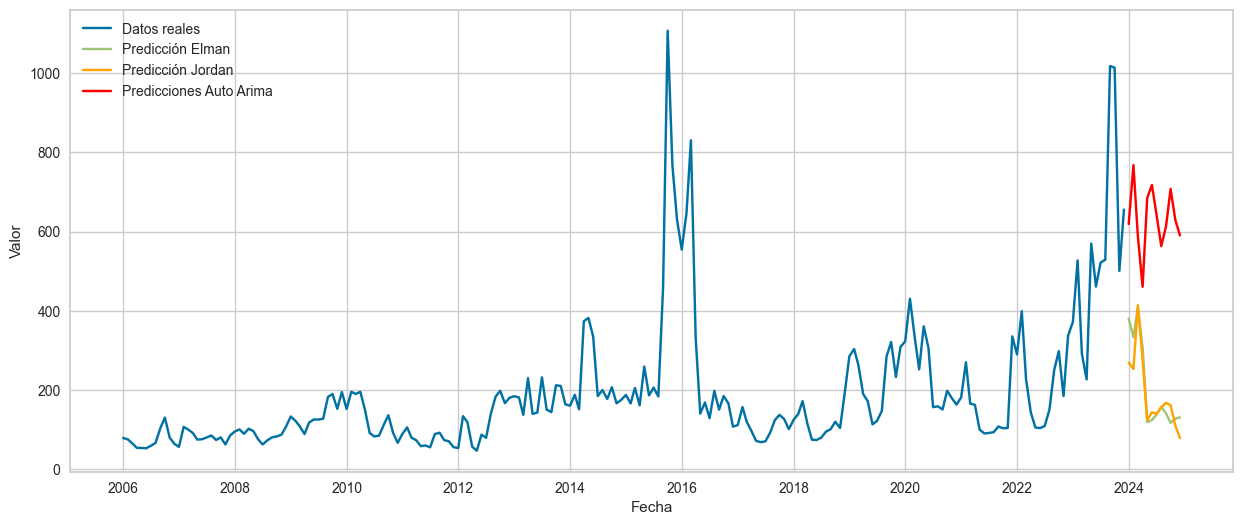

In [320]:
# Plotear los resultados
plt.figure(figsize=(15, 6))
plt.plot(data['fechaoperacion'], data_pru, label='Datos reales')
plt.plot(future_dates, new_pred, label='Predicción Elman')
plt.plot(future_dates, new_pred_jordan, label='Predicción Jordan',color='orange')
plt.plot(ab['ano'][1:], ab['valor'][1:], label='Predicción Auto Arima',color='red')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

La elección del modelo Auto ARIMA como el más adecuado para este análisis se fundamenta en su capacidad probada para proporcionar predicciones precisas y confiables en series temporales. Sin embargo, los modelos Elman RNN y Jordan RNN ofrecen alternativas valiosas en situaciones donde la complejidad temporal y la estructura secuencial de los datos son cruciales. Esta comparación resalta la importancia de seleccionar el modelo adecuado según las características específicas del conjunto de datos y los objetivos del análisis de series temporales.